# Finite difference modeling

*Prof. dr.ir.T.N.Olsthoorn*

*Heemstede, Sept. 2016, 24 May 2017*

## Approach

In this chapter we set-up a 3D steady-state finite difference model from scratch. We do this by computing a numerical groundwater problem step by step, by hand, using finite difference, building up the pieces of the model, which we will assemble in the next chapter.

## Setup of the model by specifying its dimensions

The 3D steady state FDM will be based on a regular grid consisting of rows an columns and layers. The column widths and the row heigts are constant on a per column and per row basis, but the layer thickness can vary on a cell by cell basis. The grid of a full 3D model will thus be specified in general by a vector of x cell boundary coordinates, a vector y row boundary coordinates and a full 3D array of cell top and bottom coordinates.

Notice that the arrays are interpreted as [z, y, x] or [layer row col]. This is a convenience in Python where when Phi is a 3D array of the shape of the grid [Nz, Ny, Nz] we have

Phi[k].shape is [Ny, Nx], the entire layer number i.
Phi[k][j] = Nx, the entire row j of layer i.
Phi[k][j][i] = the head in cell [k, j, i] which is the same as Phi[k, j, i]

In [1]:
import numpy as np

# specify a rectangular grid
x = np.arange(-1000., 1000., 25.)
y = np.arange(-1000., 1000., 25.) # backward, i.e. first row grid line has highest y
z = np.arange(-100., 0., 20.)  # backward, i.e. from top to bottom

From these coordinates we obtain the number of cells along each axis and the cell sizes and

In [3]:
# as well as the number of cells along the three axes
Nx = len(x)-1
Ny = len(y)-1
Nz = len(z)-1

sz = (Nz,Ny,Nx)  # the shape of the model
Nod = np.prod(sz) # total number of cells in the model

# from this we have the width of columns, rows and layers
dx = np.diff(x).reshape(1, 1, Nx)
dy = np.diff(y).reshape(1, Ny,1)
dz = np.abs(np.diff(z)).reshape(Nz, 1,1)

## IBOUND array - telling which cells are active and which have a prescribed head

Let's first specify which of the cells have their head prescrided and which cells are inactive. We have to tackle inactive cells early to make sure their conductance is made zero (in case there conductivities might be specified as non-zeros).

We do that my means of a so-called boundary array IBOUND (MODFLOW terminology), which is an integer array of the shape of the model grid that tells which cells have a prescribed head, which cells are inactive (i.e. which cells does not take part of the computation, such as cells that represent impermeable rock) and for which cells the head should be computed.

* IBOUND > 0,  means heads will be computed
* IBOUND == 0, means  cells are inactive
* IBOUND <0 ,  means heads prescribed

In this particular example we specify that the vertical zx plane at the last row of the model will have prescribed heads equal to zero.

In [7]:
IBOUND = np.ones(sz)
IBOUND[:,-1,:] = -1  # last row of model heads are prescribed
IBOUND[:, 40:45, 20:70]=0 # these cells are inactive

This boundary array makes it easy telling which cells cells are active (head computed), inactive, and fixed-head.

In [8]:
active = (IBOUND>0).reshape(Nod)  # active is now a vector of booleans of length Nod
inact  = (IBOUND==0).reshape(Nod) # dito for inact
fxhd   = (IBOUND<0).reshape(Nod)  # dito for fxhd

## Cell conductancies: defining the ease of flow between adjacent cells

The first thing to define based on the properties of the cells is the flow resistance of each cell in the 3 grid directions, `x`, `y` and `z`. For that we need the cell sizes from the coordinates and the hydraulic conductivities in the `x`, `y` and `z` direction. The latter are given as full 3D arrays `kx`, `ky`, `kz` whose shapes correspond to that of the model mesh.

In [9]:
k = 10.0 # m/d uniform conductivity
kx = k * np.ones(sz) # [L/T] 3D kx array
ky = k * np.ones(sz) # [L/T] 3D ky array with same values as kx 
kz = k * np.ones(sz) # [L/T] 3D kz array with same values as kx

The flow resistances for each cell is the head loss across opposite cell faces due to a unit flux through the cell along the axis perperndicular to them. These resistances are cell properties that can immediately be computed for the entire grid of the model. Because we always need the resistance between the cell center and its outer faces, we use the factor 0.5 (flow over half the lenght of the cell in each direction)

In [10]:
# half cell flow resistances
Rx = 0.5 * dx / (dy * dz) / kx  # [T/L2], flow resistance half cell in x-direction
Ry = 0.5 * dy / (dz * dx) / ky  # same in y-direction
Rz = 0.5 * dz / (dx * dy) / kz  # same in z-direction

Make inactive cells inactive by setting their resistance to np.Inf (infinite):

In [11]:
Rx = Rx.reshape(Nod,); Rx[inact] = np.Inf; Rx=Rx.reshape(sz)
Ry = Ry.reshape(Nod,); Ry[inact] = np.Inf; Ry=Ry.reshape(sz)
Rz = Rz.reshape(Nod,); Rz[inact] = np.Inf; Rz=Rz.reshape(sz)

From this we compute the conductance between each pair of adjacent cells across their connecting cell face. The conductance is just the reverse of the resistance of the two connected half cells. This resistance is the sum of the resistances of the two connected half cells because these resistances are placed in series with respect to the flow.

In [12]:
# conductances between adjacent cells
Cx = 1 / (Rx[:, :, :-1] + Rx[:, :,1:]) # [L2/T] in x-direction
Cy = 1 / (Ry[:, :-1,:] + Ry[:, 1:,:]) # idem in y-direction
Cz = 1 / (Rz[:-1,:,:] + Rz[1:,:,:]) # idem in z-direction

## Setting up the system matrix - set of water balance equations

The system matrix has size of (`Nod`, `Nod`) allowing a connection between each pair of cells. Of course only cells that share their cell face are connected in reality. In a 3D model this means that each cell is connected to its 6 neighbors instead of to all other cells in the model. This means that most of the matrix entries will be zero.

To be able to indentify adjacent cells we generate cell numbers in an array that has the size of the model grid:

In [14]:
NOD = np.arange(Nod).reshape(sz) # this is a full 3D array of node numbers (cell numbers)

With this array it's easy to identify adjacent cells by their cell number. Thus we generate arrays with the cel numbers of right hand neigbor of the cells (east neighbor), the left hand neighbor (the west neigbor), the north neighbor, south neighbor, the top neighbor and the bottom neighbor as follows

In [15]:
IE = NOD[:, :, 1:] # numbers of the eastern neighbors of each cell
IW = NOD[:, :, :-1] # same western neighbors
IN = NOD[:, :-1,:] # same northern neighbors
IS = NOD[:, 1:,:] # southern neighbors
IT = NOD[:-1,:,:] # top neighbors
IB = NOD[1:,:,:] # bottom neighbors

Notice that the shape of the `IE` and `IW` is the same as that of `Cx`, the size of `IN` and `IS` is the same as that of `Cy` and the size of `IT` and `IB` is the same as that of `Cx`.

To put the conductances into the system matrix we need their row and column indices together with their value, so that we can say `a`[`j`,`i`] = `value`. Because we have the numbers of adjacent cells in the arrays `IE`, `IW` etc, we can immediately place all the system matrix coefficiencts at the place into a sparse matrix.

In [16]:
import scipy.sparse as sp

R = lambda x : x.ravel() # define short hand for x.ravel()

# notice the call signature:
#      csc_matrix( (data, (row_index, col_index) ), (M,N)); This is a tuple within tuple.
A = sp.csc_matrix(( np.concatenate(( R(Cx), R(Cx), R(Cy), R(Cy), R(Cz), R(Cz)) ),\
                   (np.concatenate(( R(IE), R(IW), R(IN), R(IS), R(IB), R(IT)) ),\
                    np.concatenate(( R(IW), R(IE), R(IS), R(IN), R(IT), R(IB)) ),\
                  )),(Nod,Nod))

We now have to define the diagonal elements of the system matrix `A`, i.e. the values `a`[`i`,`i`] for `i`=[0:`Nod`].

These are just the negative sum of the row coefficients. Hence we sum `A` over the second axis (`axis`=1) to get them in a [`Nod`,1] sized vector. (Notice stat sparace matrix derived vectors keep their orientation, contrary to vectors obained from numpy arrays, which produce dimensionless vectors).

Generate the diagonal values:

In [17]:
# to use the vector of diagonal values int a call of sp.diags() we need to have it aa a 
# standard nondimensional numpy vector.
# To get this:
# - first turn the matrix obtained by A.sum(axis=1) into a np.array by np.array( .. )
# - then take the whole column to loose the array orientation (to get a dimensionless numpy vector)
adiag = np.array(-A.sum(axis=1))[:,0]

Then generate a diagonal array from these values, that we can add it to `A`, to complete `A`.

In [18]:
Adiag = sp.diags(adiag)

More complex alternative: Generate diagonal array by calling the csr_matrix constructor:

Adiag = sp.csr_matrix((adiag,(np.arange(Nod),np.arange(Nod))),(Nod,Nod))

## Boundary conditions

For this chapter we only use fixed flow and fixed head boundary conditions.

### Fixed flows

Fixed flow boundary conditions are specified by an 3D array of the size of the grid. Each values specifies the inflow for the corresponding cell (injections are positive). Cells without a specified flow are, in fact, cells where the specified flow is zero. Hence the fixed-flows array is a full 3D array with flow values that are zero where no flow enters or leaves the cells and have non-zero values elsewhere.

For this example, we specify a single extraction of Q=-1200 m3/d in cell [30,25,2]:

In [19]:
FQ = np.zeros(sz)    # all flows zero. Note sz is the shape of the model grid
FQ[2, 30, 25] = -1200  # [m3/d] extraction in this cell

The righ-hand size of the matrix equation to be solved, the vector RHS, contains the flows. So we can generate it by assignment of `FQ` and converting it to a numpy vector

In [20]:
RHS = FQ.reshape(Nod)

See further down how we use `RHS` for only the active and non-fixed head rows.

The next step is to add fixed head boundary conditions.

### Fixed heads

Fixed heads are known heads. This implies that in the set of equations that represent the model, i.e

$A \times Phi = RHS$

Some of the Phis are prescribed and should not be computed as defined by `IBOUND` and contained in the boolean vectors `active`, `fxhd` and `inact` specified and computed above.

Now that we know which cell have fixed heads, we can multiply out these heads with the corresponding columns of the system matrix, which yields a vector of constant values with dimension flow [m3/d] that can be added to the fixed flow vector in the `RHS` vector. The `RHS` vector is now the sum of the `FQ` and the contribution from the fixed heads.

Notice that the fixed heads will be obtained from the given array `HI` of the initial heads, where the head in the cells where `IBOUND`>0 correspond with the fixed heads.

In [21]:
HI = np.zeros(sz)

We reshape `FQ` and `HI` to a column vector to allow matrix multiplication

In [22]:
RHS = FQ.reshape(Nod,1) - A[:,fxhd].dot(HI.reshape(Nod,1)[fxhd])

We have now the complete `RHS` of the matrix equation to solve:

$A \times Phi = RHS$

## Solving the matrix equation for the unknown heads

We use the sparse matrix solver in module `scipy.sparse.linalg` to compute the unknown heads.

In [23]:
from scipy.sparse.linalg import spsolve # import with from to use its short name

Of course we only need the active rows and columns of `A` and the active rows from `RHS`.

But first allocate a full-fledged vector of heads to store the result.

In [24]:
Phi = HI.flatten() 

Then compute the unknown heads (i.e. the active cels only).

Remark: If we want to select a submatrix from `A` defiend by a given vectors of row and column indices, we can do so in sequence: Rows (I) first, columns (J) next, like so:

$A[I][:,J]$

which we apply in the next line

In [25]:
 Phi[active] = spsolve( (A+Adiag)[active][:,active] ,RHS[active] )

At this point we solved the problem and now have the heads for all cells in the vector Phi.

We didn't touch the rows and columns that are inactive. So the heads of these inactive cells whatever they are in `HI` are know still in `Phi`. Just to make sure we detect them and won't use them, set them to `NaN` (Not a Number).

In [26]:
Phi[inact] = np.NaN

Finally we reshape the head vector to that of the model grid.

In [27]:
Phi=Phi.reshape(sz) # reshape vector Phi to 3D shape of the grid

In [28]:
Phi # show Phi

array([[[ 1.77107246,  1.77132861,  1.77183761, ...,  1.56399507,
          1.56320139,  1.56280385],
        [ 1.77081631,  1.77107575,  1.77159133, ...,  1.56360172,
          1.56280525,  1.56240631],
        [ 1.77030071,  1.77056677,  1.77109553, ...,  1.56281367,
          1.56201158,  1.56160982],
        ..., 
        [ 0.05529699,  0.05524583,  0.0551436 , ...,  0.03419641,
          0.03426788,  0.03430386],
        [ 0.02763571,  0.02761016,  0.02755909, ...,  0.01708962,
          0.01712512,  0.01714299],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 1.77107246,  1.77132861,  1.77183761, ...,  1.56399507,
          1.56320139,  1.56280385],
        [ 1.77081631,  1.77107575,  1.77159133, ...,  1.56360172,
          1.56280525,  1.56240631],
        [ 1.77030071,  1.77056677,  1.77109553, ...,  1.56281367,
          1.56201158,  1.56160982],
        ..., 
        [ 0.05529699,  0.05524583,  0.0551436 , ...,

## Plotting the heads as contours

Import the required plotting module and setup the plot.

In [29]:
%matplotlib notebook
import matplotlib.pyplot as plt # combines namespace of numpy and pyplot

For coordinates of the cells use their centers.

In [30]:
xm = 0.5 * (x[:-1] + x[1:]) # [L] coordinates of column centers
ym = 0.5 * (y[:-1] + y[1:]) # [L] coordinates of row centers
layer = 2 # contours for this layer
nc = 50   # number of contours in total

Plot the results using plt functions like in Matlab

<IPython.core.display.Javascript object>


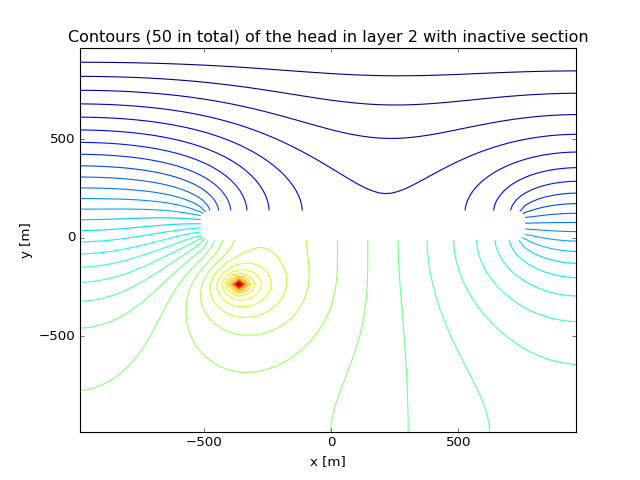

In [31]:
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title("Contours (%d in total) of the head in layer %d with inactive section" % (nc, layer))
plt.contour(xm, ym, Phi[layer], nc)

* The white area is the aquifer part that was defined as inactive (impervious).
* The red trough is the well location.
* The two flanks and the front sides are closed (no FQ and no fixed head).
* The head at the back side is prescribed and maintained at zero.

## Conclusion

In this chapter we have developed, from scratch, a full 3D finite difference model for which fixed heads, fixed flows and inactive subareas are be prescribed. While developing we also computed a concrete example of which the head contours were finally shown.

To turn this model into a general Python function that can compute arbitrary 3D steady-state models of this kind, we only have to gather the developed lines and put them under a function definition, add some help strings (a doc string) and add error checking for convenience, while the data for this specific case, like the grid dimensions (`x`,`y`,`z`) the conductivities (`kx`,`ky`,`kz`), the prescribed flows `FQ` and initial heads `HI` plus the boundary array `IBOUND` that tells which cells have fixed heads and which are inactive, are to be passed as in user-given arguments at the function call like so:

Phi = fdm3(x,y,z,kx,ky,kz,FQ,IH,IBOUND) # function that solves arbitrary 3D steady steate finite difference model

We do this in the next section.